In [36]:
import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.image import imread
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
from math import sqrt, pi, log
from statistics import median, mean
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"

In [37]:
def get_params(image):

    size = image.shape[0]
    negated = cv2.bitwise_not(image)
    nlabels, _, stats, _ = \
        cv2.connectedComponentsWithStats(
            image=negated,
            labels=None,
            stats=None,
            centroids=None,
            connectivity=8,
            ltype=cv2.CV_32S
        )

    thicknesses, areas = [], []
    for i in range(1, nlabels):        
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        areas.append(area)
        bbox_diagonal = sqrt((w**2 + h**2))
        thickness = area / bbox_diagonal
        thicknesses.append(thickness)
    
    radius = size / 2
    tca = 1e4 * sum(areas) / (pi * radius**2)

    lengths = [area * 32 / size / median(thicknesses) for area in areas]    

    n, total_nc = 5, 0
    for i in range(1, n + 1):
        ith_line = negated[i * size // (n + 1)]
        for j in range(len(ith_line) - 1):
            if ith_line[j] == 0 and ith_line[j + 1] == 255:
                total_nc += 1
    cd = total_nc / n / 0.032

    return {
        "tca": tca,
        "lengths": lengths,
        "avg_length": median(lengths),
        "25_length": np.percentile(lengths, 25),
        "75_length": np.percentile(lengths, 75),
        "total_cracks": len(lengths),
        "cd": cd,
    }

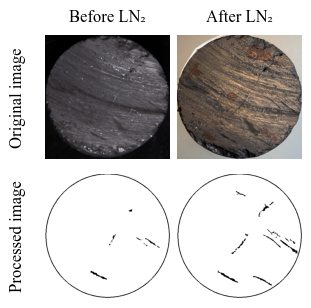

<Figure size 640x480 with 0 Axes>

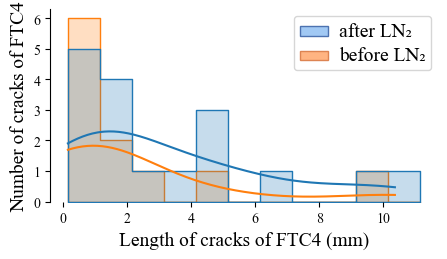

<Figure size 640x480 with 0 Axes>

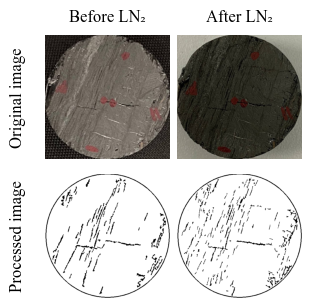

<Figure size 640x480 with 0 Axes>

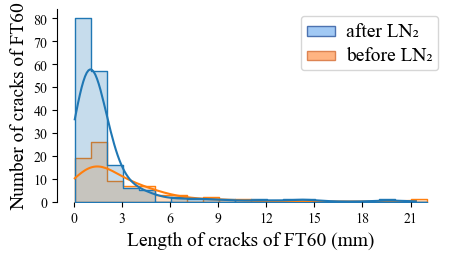

<Figure size 640x480 with 0 Axes>

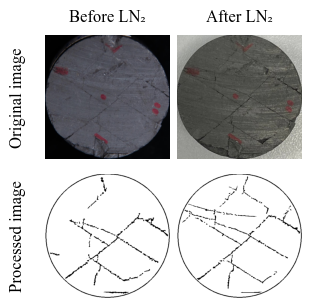

<Figure size 640x480 with 0 Axes>

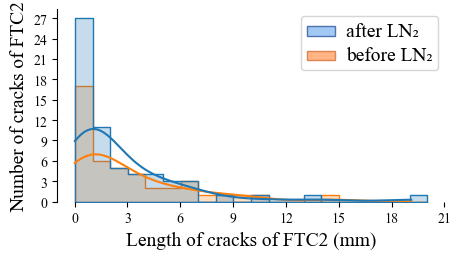

<Figure size 640x480 with 0 Axes>

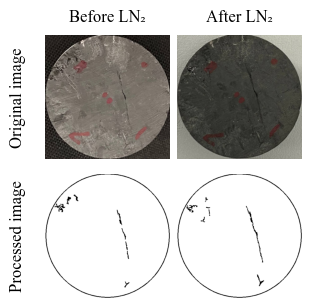

<Figure size 640x480 with 0 Axes>

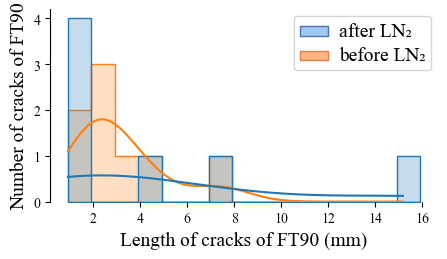

<Figure size 640x480 with 0 Axes>

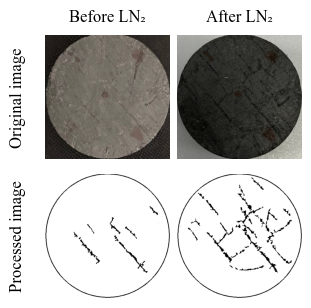

<Figure size 640x480 with 0 Axes>

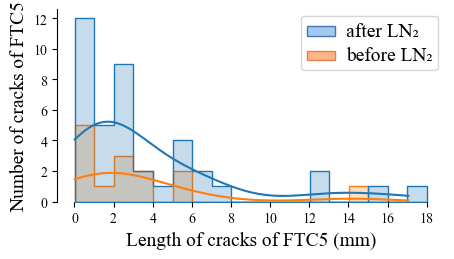

<Figure size 640x480 with 0 Axes>

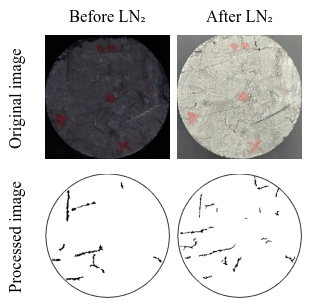

<Figure size 640x480 with 0 Axes>

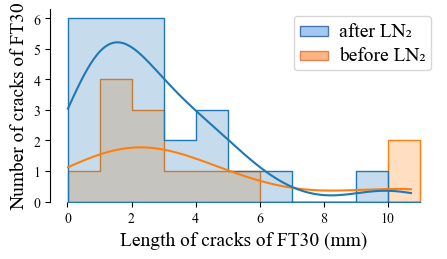

<Figure size 640x480 with 0 Axes>

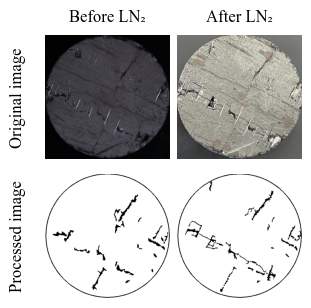

<Figure size 640x480 with 0 Axes>

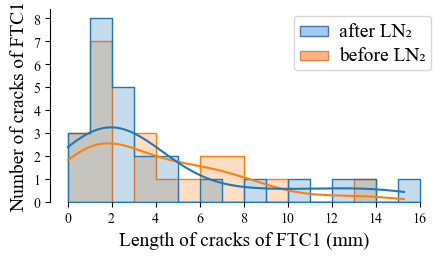

<Figure size 640x480 with 0 Axes>

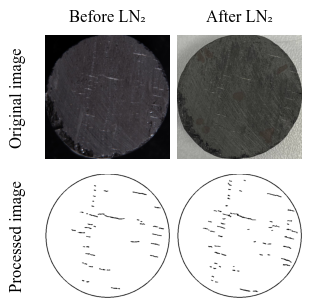

<Figure size 640x480 with 0 Axes>

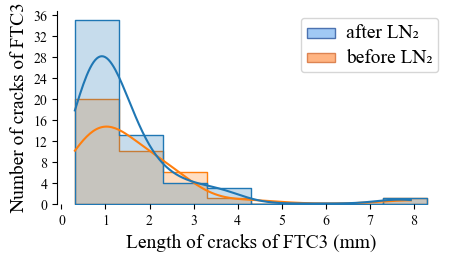

<Figure size 640x480 with 0 Axes>

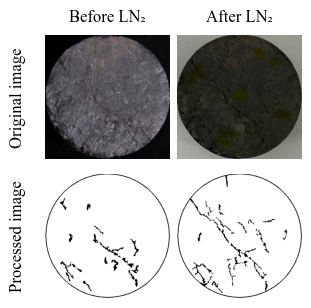

<Figure size 640x480 with 0 Axes>

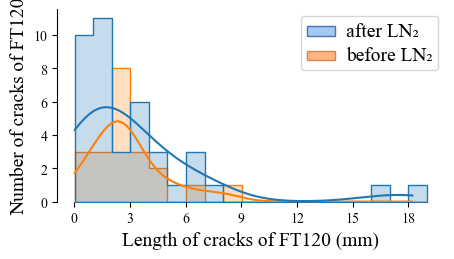

<Figure size 640x480 with 0 Axes>

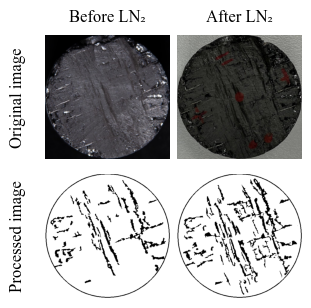

<Figure size 640x480 with 0 Axes>

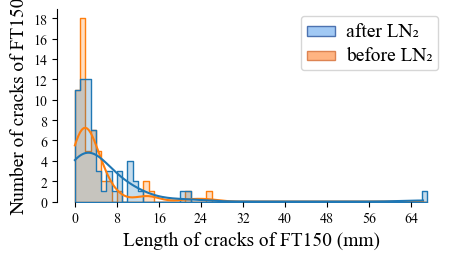

<Figure size 640x480 with 0 Axes>

In [38]:
sample_to_process = {
    1: "FTC4",
    2: "FT60",
    3: "FTC2",
    4: "FT90",
    5: "FTC5",
    6: "FT30",
    7: "FTC1",
    8: "FTC3",
    9: "FT120",
    10: "FT150",
}

param_names = [
    "tca",
    "avg_length",
    "25_length",
    "75_length",
    "total_cracks",
    "cd",
]

data = {}
for when in ["after", "before"]:
    data[when] = {"Sample": [], "process": []}

for sample in range(1, 11):
    lengths_data = {}
    path = f"data/{sample}/"
    fig = plt.figure(
        constrained_layout=True,
        figsize=(3, 3),
    )
    gs = fig.add_gridspec(2, 2)

    f_ax1 = fig.add_subplot(gs[0, 0])
    img = imread(path + "before/original.jpg")
    img = cv2.resize(img, (640, 640))
    f_ax1.imshow(img)
    f_ax1.set_title(
        label=f"Before LN₂",
        pad=10,
    )
    f_ax1.set_ylabel(
        ylabel="Original image",
        fontsize=12,
        labelpad=10,
    )

    f_ax2 = fig.add_subplot(gs[0, 1])
    img = imread(path + "after/original.jpg")
    img = cv2.resize(img, (640, 640))
    f_ax2.imshow(img)
    f_ax2.set_title(
        label=f"After LN₂",
        pad=10,
    )

    f_ax3 = fig.add_subplot(gs[1, 0])
    img = imread(path + "before/transformed.bmp")
    img = cv2.circle(img, (240, 240), 237, 0, 2)
    f_ax3.imshow(img, cmap="gray")
    f_ax3.set_ylabel(
        ylabel="Processed image",
        fontsize=12,
        labelpad=10,
    )

    f_ax4 = fig.add_subplot(gs[1, 1])
    img = imread(path + "after/transformed.bmp")
    img = cv2.circle(img, (240, 240), 237, 0, 2)
    f_ax4.imshow(img, cmap="gray")

    for ax in [f_ax1, f_ax2, f_ax3, f_ax4]:
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.savefig(f"results/processes/{sample_to_process[sample]}/grid.png", dpi=300)
    plt.show()
    plt.clf()    

    for when in ["after", "before"]:
        transformed = cv2.imread(path + when + "/transformed.bmp", 1)
        transformed = cv2.cvtColor(transformed, cv2.COLOR_BGR2GRAY)
        params = get_params(transformed)
        for param in param_names:
            if param in data[when]:
                data[when][param].append(params[param])
            else:
                data[when][param] = [params[param]]
        lengths_data[when] = params["lengths"]
        data[when]["process"].append(sample_to_process[sample])
        data[when]["Sample"].append(sample)

    fig = plt.figure(figsize=(5, 2.5))
    ax = fig.add_subplot()
    g = sns.histplot(
        data=lengths_data,
        kde=True,
        linewidth=1,
        element="step",
        binwidth=1
    )
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set(ylabel=None)
    
    pastel = sns.color_palette("pastel")
    deep = sns.color_palette("deep")

    legend_elements = [
        Patch(deep[0], pastel[0], label="after LN₂"),
        Patch(deep[1], pastel[1], label="before LN₂"),
    ]
    ax.legend(handles=legend_elements)

    plt.xlabel(f"Length of cracks of {sample_to_process[sample]} (mm)", fontsize=14)
    plt.ylabel(f"Number of cracks of {sample_to_process[sample]}", fontsize=14)
    plt.setp(g.get_legend().get_texts(), fontsize='14') 
    # plt.savefig(
    #     f"results/processes/{sample_to_process[sample]}/graph.svg",
    #     format="svg",
    #     bbox_inches='tight'
    # )
    plt.savefig(
        f"results/processes/{sample_to_process[sample]}/graph.png",
        dpi=600,
        bbox_inches='tight'
    )
    plt.show()
    plt.clf()

In [39]:
df_before = pd.DataFrame.from_dict(data["before"]).set_index("Sample")
df_before["when"] = "before"
df_after = pd.DataFrame.from_dict(data["after"]).set_index("Sample")
df_after["when"] = "after"
df_after

,process,tca,avg_length,25_length,75_length,total_cracks,cd,when
Sample,,,,,,,,
1,FTC4,150.810361,1.444918,1.135292,4.892078,17,50.00,after
2,FT60,537.811079,1.069008,0.680278,1.684497,173,300.00,after
3,FTC2,358.153884,1.284583,0.503758,3.778186,61,106.25,after
4,FT90,95.548228,1.891077,1.291924,5.897914,7,31.25,after
5,FTC5,500.895974,2.154790,0.954964,5.317598,40,131.25,after
6,FT30,201.098902,2.059070,1.143401,3.629467,26,68.75,after
7,FTC1,364.177457,2.159381,1.444999,4.180756,26,93.75,after
8,FTC3,168.383719,0.953799,0.737605,1.551513,56,43.75,after
9,FT120,381.419242,1.863246,1.070886,4.048238,40,75.00,after


In [40]:
df_before

,process,tca,avg_length,25_length,75_length,total_cracks,cd,when
Sample,,,,,,,,
1,FTC4,51.393784,0.753309,0.489651,2.121820,11,12.50,before
2,FT60,521.674536,1.753210,1.040615,3.710019,78,200.00,before
3,FTC2,341.243671,1.675997,0.674615,4.168911,44,93.75,before
4,FT90,84.827374,2.459190,1.951673,3.664028,8,18.75,before
5,FTC5,162.470671,2.219459,0.878230,3.307141,14,43.75,before
6,FT30,195.959524,2.521253,1.594522,4.592768,13,37.50,before
7,FTC1,352.738195,3.477764,1.417353,6.076244,21,62.50,before
8,FTC3,129.479178,1.207786,0.743742,2.002383,38,37.50,before
9,FT120,296.260295,2.482375,1.787310,3.353964,21,37.50,before


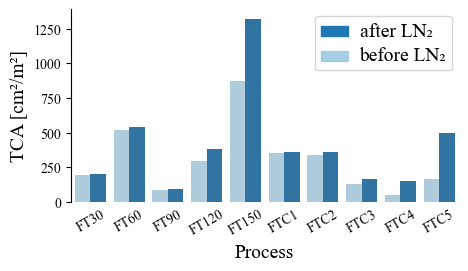

<Figure size 640x480 with 0 Axes>

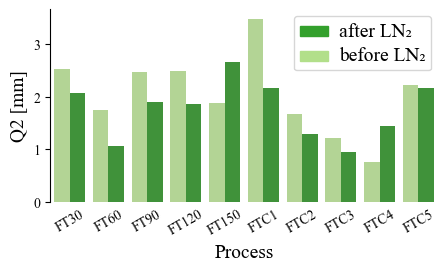

<Figure size 640x480 with 0 Axes>

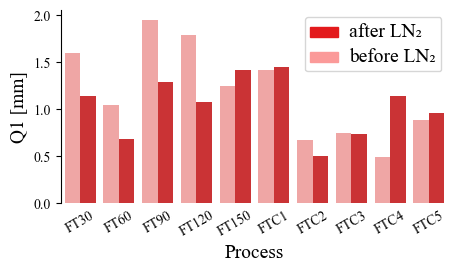

<Figure size 640x480 with 0 Axes>

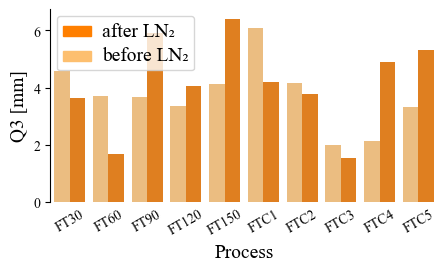

<Figure size 640x480 with 0 Axes>

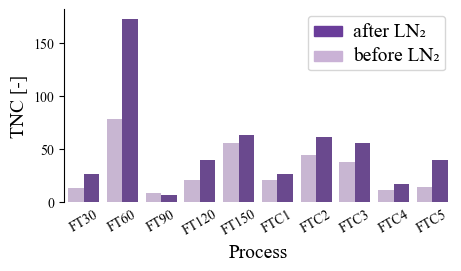

<Figure size 640x480 with 0 Axes>

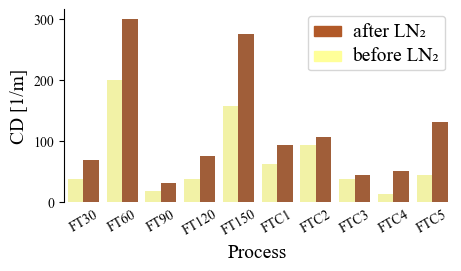

<Figure size 640x480 with 0 Axes>

In [41]:
df = pd.concat([df_before, df_after]).reset_index()

order = [
    "FT30", "FT60", "FT90", "FT120", "FT150",
    "FTC1", "FTC2", "FTC3", "FTC4", "FTC5",
]

ylabel = {
    "tca": "TCA [cm²/m²]",
    "avg_length": "Q2 [mm]",
    "25_length": "Q1 [mm]",
    "75_length": "Q3 [mm]",
    "total_cracks": "TNC [-]",
    "cd": "CD [1/m]",

}
pal = sns.color_palette("Paired")

for i, param in enumerate(param_names):
    
    before_color, after_color = pal[2*i], pal[2*i+1]
    fig, ax = plt.subplots(figsize=(5, 2.5))

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.bottom.set_visible(False)

    g = sns.barplot(
        data=df,
        x='process', 
        y=param,
        hue='when',
        order=order,
        palette=[before_color, after_color],
        dodge=True
    )

    legend_elements = [
        Patch(after_color, after_color, label="after LN₂"),
        Patch(before_color, before_color, label="before LN₂"),
    ]

    ax.legend(handles=legend_elements)
    ax.tick_params(axis='x', rotation=30, length=0, left=False)
    ax.set(xlabel=None, ylabel=None)
    plt.ylabel(ylabel[param], fontsize=14)
    plt.xlabel("Process", fontsize=14)
    plt.setp(g.get_legend().get_texts(), fontsize='14') 
    plt.savefig(f"results/{param}.png", dpi=600, bbox_inches='tight')
    plt.show()
    plt.clf()

In [42]:
change = {
    f"{param}_change": df_after[param] / df_before[param] - 1 \
    for param in param_names
}

df_change = pd.DataFrame(change)
df_change["process"] = [sample_to_process[sample] for sample in df_change.index]
df_change.to_csv("results/change.csv")
df_change

,tca_change,avg_length_change,25_length_change,75_length_change,total_cracks_change,cd_change,process
Sample,,,,,,,
1,1.934409,0.918095,1.318576,1.305605,0.545455,3.000000,FTC4
2,0.030932,-0.390257,-0.346274,-0.545960,1.217949,0.500000,FT60
3,0.049555,-0.233541,-0.253266,-0.093723,0.386364,0.133333,FTC2
4,0.126384,-0.231016,-0.338043,0.609680,-0.125000,0.666667,FT90
5,2.082993,-0.029137,0.087374,0.607914,1.857143,2.000000,FTC5
6,0.026227,-0.183315,-0.282919,-0.209743,1.000000,0.833333,FT30
7,0.032430,-0.379089,0.019506,-0.311951,0.238095,0.500000,FTC1
8,0.300469,-0.210292,-0.008252,-0.225166,0.473684,0.166667,FTC3
9,0.287446,-0.249410,-0.400839,0.207001,0.904762,1.000000,FT120


In [43]:
df_change = (
    df_change
        .assign(
            process = lambda x: pd.Categorical(
            x['process'],
            categories=order,
            ordered=True)
        )
        .sort_values('process')
)
df_change

,tca_change,avg_length_change,25_length_change,75_length_change,total_cracks_change,cd_change,process
Sample,,,,,,,
6,0.026227,-0.183315,-0.282919,-0.209743,1.000000,0.833333,FT30
2,0.030932,-0.390257,-0.346274,-0.545960,1.217949,0.500000,FT60
4,0.126384,-0.231016,-0.338043,0.609680,-0.125000,0.666667,FT90
9,0.287446,-0.249410,-0.400839,0.207001,0.904762,1.000000,FT120
10,0.513780,0.418173,0.132470,0.556805,0.125000,0.760000,FT150
7,0.032430,-0.379089,0.019506,-0.311951,0.238095,0.500000,FTC1
3,0.049555,-0.233541,-0.253266,-0.093723,0.386364,0.133333,FTC2
8,0.300469,-0.210292,-0.008252,-0.225166,0.473684,0.166667,FTC3
1,1.934409,0.918095,1.318576,1.305605,0.545455,3.000000,FTC4


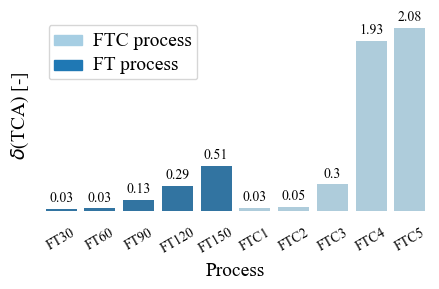

<Figure size 640x480 with 0 Axes>

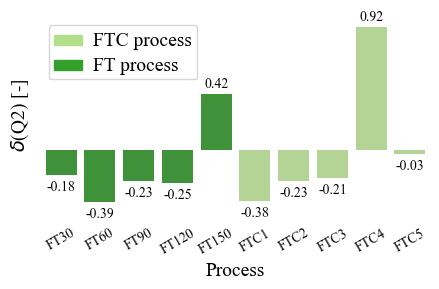

<Figure size 640x480 with 0 Axes>

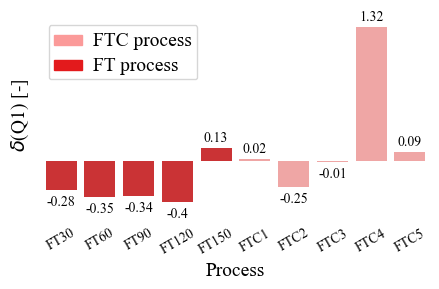

<Figure size 640x480 with 0 Axes>

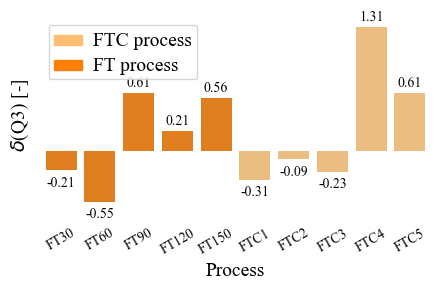

<Figure size 640x480 with 0 Axes>

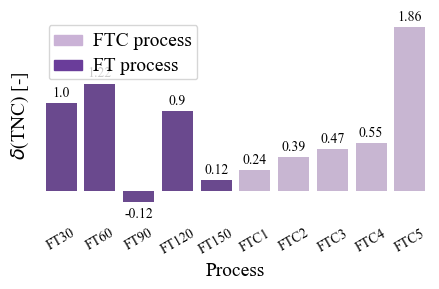

<Figure size 640x480 with 0 Axes>

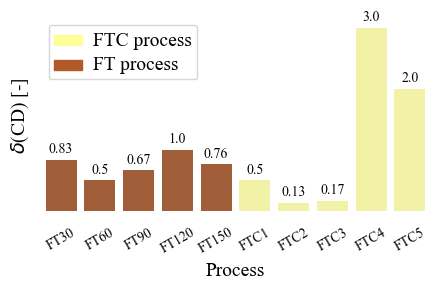

<Figure size 640x480 with 0 Axes>

In [44]:
pal = sns.color_palette("Paired")

change_names = [
    "tca_change",
    "avg_length_change",
    "25_length_change",
    "75_length_change",
    "total_cracks_change",
    "cd_change",
]

ylabel = {
    "tca_change": "$\delta$(TCA) [-]",
    "avg_length_change": "$\delta$(Q2) [-]",
    "25_length_change": "$\delta$(Q1) [-]",
    "75_length_change" : "$\delta$(Q3) [-]",
    "total_cracks_change": "$\delta$(TNC) [-]",
    "cd_change": "$\delta$(CD) [-]",
}

for i, change in enumerate(change_names):

    ftc_color, ft_color = pal[2*i], pal[2*i + 1]
    
    colors = [
        ftc_color if c.startswith("FTC") else \
        ft_color for c in df_change["process"]
    ]

    fig, ax = plt.subplots(figsize=(5, 2.5))
    g = sns.barplot(
        data=df_change,
        x='process', 
        y=change,
        palette=colors,
        ax=ax,
    )

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.bar_label(
        ax.containers[0],
        labels=round(df_change[change], 2),
        padding=3,
    )

    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.tick_params(axis='x', rotation=30, pad=10, length=0, left=False)
    ax.set(xlabel=None, ylabel=None)

    legend_elements = [
        Patch(ftc_color, ftc_color, label='FTC process'),
        Patch(ft_color, ft_color, label='FT process'),
    ]
    ax.legend(handles=legend_elements)

    plt.ylabel(ylabel[change], fontsize=14)
    plt.xlabel("Process", fontsize=14)
    plt.setp(g.get_legend().get_texts(), fontsize='14') 
    # plt.savefig(f"results/{change}.svg", format="svg", bbox_inches='tight')
    plt.savefig(f"results/{change}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()